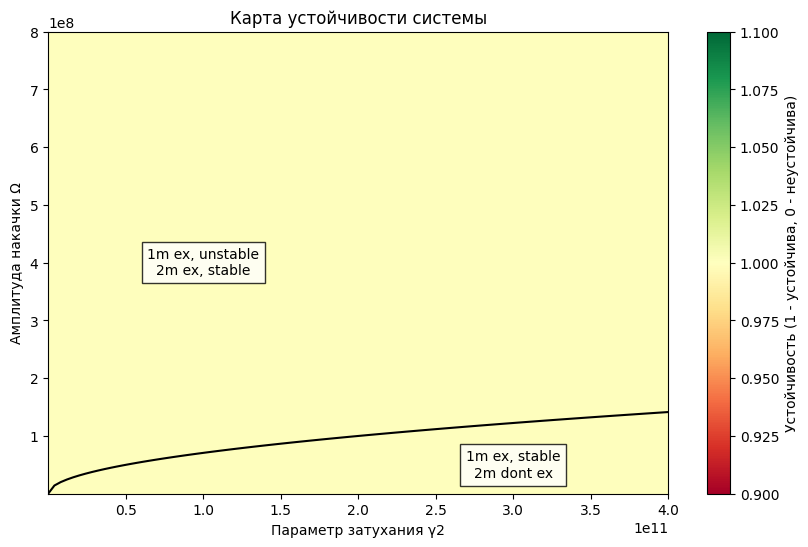

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig

def build_matrix(alpha, beta, Omega, gammas):
    a1_ph = np.pi / 2
    a2_ph = -np.pi / 4 
    b_ph = 3 * np.pi / 4
    
    try:
        a1_st = (gammas[0] * gammas[2]) / (4 * alpha * beta) * np.exp(1j * a1_ph)
        a2_st_abs = np.sqrt(max(0, Omega / np.abs(a1_st) - gammas[1]/2))  
        a2_st = a2_st_abs * (gammas[0]/(2*alpha*beta)) * np.exp(1j * a2_ph)
        b_st = (2/gammas[0]) * beta * a2_st * a1_st * np.exp(1j * b_ph)
    except:
        return None 
    
    M = np.zeros((6, 6), dtype=complex)
    
    M[0, 0] = -1 / 2 * gammas[1]
    M[0, 1] = 1j * alpha * b_st 
    M[0, 2] = 1j * alpha * a2_st

    M[1, 1] = -1 / 2 * gammas[2]
    M[1, 0] = 1j * alpha * np.conj(b_st) 
    M[1, 5] = 1j * alpha * a1_st

    M[2, 0] = 1j * beta * np.conj(a2_st)
    M[2, 2] = -1 / 2 * gammas[0]
    M[2, 4] = 1j * beta * a1_st

    M[3, 4] = -1j * alpha * np.conj(b_st)
    M[3, 3] = -1 / 2 * gammas[1]
    M[3, 5] = -1j * alpha * np.conj(a2_st)

    M[4, 2] = -1j * alpha * np.conj(a1_st)
    M[4, 3] = -1j * alpha * np.conj(b_st)
    M[4, 4] = -1 / 2 * gammas[2]

    M[5, 1] = -1j * beta * np.conj(a1_st)
    M[5, 3] = -1j * beta * a2_st
    M[5, 5] = -1 / 2 * gammas[0]

    return M

def stability_analysis(Omega_range, gammas_range, alpha=1e16, beta=4e12):
    stability_map = np.zeros((len(Omega_range), len(gammas_range)))
    
    for i, Omega_k in enumerate(Omega_range):
        for j, gamma_k in enumerate(gammas_range):
            current_gammas = np.array([2e11, 2e12, gamma_k*2e11])
            M = build_matrix(alpha, beta, Omega_k*4e8, current_gammas)
            
            if M is None: 
                stability_map[i, j] = np.nan
                continue
                
            try:
                eigenvalues = eig(M)[0]
                max_real = np.max(np.real(eigenvalues))
                stability_map[i, j] = 1 if max_real < 0 else 0
            except:
                stability_map[i, j] = np.nan
            
    return stability_map

Omega_values = np.linspace(1e-8, 2, 100)
gamma_values = np.linspace(1e-8, 2, 100)

stability_results = stability_analysis(Omega_values, gamma_values)

Omega_b = 1/2 * np.sqrt(1/4 * gamma_values)*4e8
Omega_zero = gamma_values
plt.figure(figsize=(10, 6))
plt.imshow(stability_results, extent=[gamma_values.min()*2e11, gamma_values.max()*2e11, 
           Omega_values.min()*4e8, Omega_values.max()*4e8], 
           aspect='auto', origin='lower', cmap='RdYlGn')
plt.plot(gamma_values*2e11, Omega_b, c='k')

plt.text(1e11, 4e8, '1m ex, unstable\n2m ex, stable', ha='center', va='center', 
         bbox=dict(facecolor='white', alpha=0.8))
plt.text(3e11, 5e7, '1m ex, stable\n2m dont ex', ha='center', va='center', 
         bbox=dict(facecolor='white', alpha=0.8))

plt.colorbar(label='Устойчивость (1 - устойчива, 0 - неустойчива)')
plt.xlabel('Параметр затухания γ2')
plt.ylabel('Амплитуда накачки Ω')
plt.title('Карта устойчивости системы')
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig

def A1_st(gammas, Omega, order):
    if order == 'zero':
        return -2j * Omega / gammas[0]
    if order == 'first':
        return -1j * np.sqrt( gammas[1] * gammas[3] / (4 * ALPHA * BETA) ) 
        
    
    if order == 'second':
        return -2j * Omega * gammas[3] / (gammas[4] * gammas[2] + gammas[0] * gammas[3])

def A2_st(gammas, Omega, order):
    if order == 'zero':
        return 0
    if order == 'first':
        return np.sqrt((Omega - gammas[0] / 2 * np.abs(A1_st(gammas, Omega, order))) / ALPHA / BETA / 2 * gammas[3] / np.abs(A1_st(gammas, Omega, order)))  # phi_2 = 0
        
    if order == 'second':
        return 1j * np.sqrt(gammas[4] * gammas[2] / (4 * ALPHA * BETA))  # phi_2 = np.pi / 2

def A3_st(gammas, Omega, order):
    if order == 'zero' or order == 'first':
        return 0
    if order == 'second':
        return np.sqrt(2 * ALPHA * BETA / gammas[3] * np.abs(A1_st(gammas, Omega, order))**2 - gammas[1] / 2)  # phi_3 = 0, phi_rho^2 = phi_rho^1 = - np.pi / 2

    
def rho1_st(gammas, Omega, order):
    if order == 'zero':
        return 0
    if order == 'first':
        return np.abs(A1_st(gammas, Omega, order)) * np.abs(A2_st(gammas, Omega, order)) * 2 * BETA / gammas[3]  # phi_rho^1 = 0
    if order == 'second':
        return -2j * BETA / gammas[3] * np.abs(A2_st(gammas, Omega, order)) * np.abs(A1_st(gammas, Omega, order)) 

def rho2_st(gammas, Omega, order):
    if order == 'zero' or order == 'first':
        return 0
    else:
        return -2j * BETA / gammas[4] * np.abs(A2_st(gammas, Omega, order)) * np.abs(A3_st(gammas, Omega, order))

def build_matrix(Omega, gammas, order):
    M = np.zeros((10, 10), dtype=complex)
    
    M[0, 0] = -1 / 2 * gammas[0]
    M[0, 1] = 1j * ALPHA * rho1_st(gammas, Omega, order)
    M[0, 3] = 1j * ALPHA * A2_st(gammas, Omega, order)

    M[1, 1] = -1 / 2 * gammas[1]
    M[1, 0] = 1j * ALPHA * np.conj(rho1_st(gammas, Omega, order))
    M[1, 2] = 1j * ALPHA * rho2_st(gammas, Omega, order)
    M[1, 4] = 1j * ALPHA * A3_st(gammas, Omega, order)
    M[1, 8] = 1j * ALPHA * A1_st(gammas, Omega, order)

    M[2, 2] = -1 / 2 * gammas[2]
    M[2, 1] = 1j * ALPHA * np.conj(rho2_st(gammas, Omega, order))
    M[2, 9] = 1j * ALPHA * A2_st(gammas, Omega, order)

    M[3, 3] = -1 / 2 * gammas[3]
    M[3, 0] = 1j * BETA * A2_st(gammas, Omega, order)
    M[3, 6] = 1j * BETA * A1_st(gammas, Omega, order)

    M[4, 4] = -1 / 2 * gammas[4]
    M[4, 1] = 1j * BETA * np.conj(A3_st(gammas, Omega, order))
    M[4, 7] = 1j * BETA * A2_st(gammas, Omega, order)

    M[5, 5] = -1 / 2 * gammas[0]          
    M[5, 6] = -1j * ALPHA * np.conj(rho1_st(gammas, Omega, order))  
    M[5, 8] = -1j * ALPHA * np.conj(A2_st(gammas, Omega, order))         

    M[6, 6] = -1 / 2 * gammas[1]
    M[6, 3] = -1j * ALPHA * np.conj(A1_st(gammas, Omega, order))         
    M[6, 5] = -1j * ALPHA * rho1_st(gammas, Omega, order)     
    M[6, 7] = -1j * ALPHA * np.conj(rho2_st(gammas, Omega, order)) 
    M[6, 9] = -1j * ALPHA * np.conj(A3_st(gammas, Omega, order)) 

    M[7, 7] = -1 / 2 * gammas[2]  
    M[7, 4] = -1j * ALPHA * np.conj(A2_st(gammas, Omega, order))           
    M[7, 6] = -1j * ALPHA * rho2_st(gammas, Omega, order)        

    M[8, 8] = -1 / 2 * gammas[3]        
    M[8, 1] = -1j * BETA * np.conj(A1_st(gammas, Omega, order))               
    M[8, 5] = -1j * BETA * np.conj(A2_st(gammas, Omega, order))     

    M[9, 9] = -1 / 2 * gammas[4]    
    M[9, 2] = -1j * BETA * np.conj(A2_st(gammas, Omega, order))          
    M[9, 6] = -1j * BETA * A3_st(gammas, Omega, order)
    # for row in M:
    #     print(row)
    return M

def stability_analysis(Omega_range, gamma_range, gamma_index, order):
    stability_map = np.zeros((len(Omega_range), len(gamma_range)))
    
    for i, Omega in enumerate(Omega_range):
        for j, gamma_val in enumerate(gamma_range):
            current_gammas = np.ones(5)

            current_gammas[gamma_index] = gamma_val
            
            M = build_matrix(Omega, current_gammas, order)
            # print(M)
            try:
                eigenvalues = eig(M)[0]
                max_real = np.max(np.real(eigenvalues))
                print(np.real(eigenvalues))
                stability_map[i, j] = 1 if max_real < TOLERANCY else 0
                print(1 if max_real < 0 else 0)
                # if stability_map[i, j] == 1:
                #     print(max_real)
            except:
                stability_map[i, j] = np.nan

            
    return stability_map

def analytical_curve1(gamma_val, gamma_index): # second mode existance 
    g = np.ones(5)
    g[gamma_index] = gamma_val
    return np.sqrt(1/(16 * ALPHA * BETA) * g[1] * (g[4] * g[2] + g[0] * g[3])**2 / g[3])

def analytical_curve2(gamma_val, gamma_index): # zero mode stability
    g = np.ones(5)
    g[gamma_index] = gamma_val
    numerator = g[0]**2 * (1 + g[1]/g[2] + g[3]/g[2]) * (g[3]*g[2] + g[1]*g[3] + g[1]*g[2])
    return np.sqrt(1/(16 * ALPHA * BETA) * numerator)

In [4]:
import numpy as np
import plotly.graph_objects as go
from scipy.linalg import eig


gammas = np.array([10, 10, 10, 1, 1])
Omega_values = np.linspace(0, 16, 1000)
ALPHA = 1
BETA = 1
TOLERANCY = np.array([0, 1e-8, -1e-9]) 

# gammas = np.array([10, 10, 10, 1, 1])
# Omega_values = np.linspace(10, 12, 2)
# ALPHA = 1
# BETA = 1
# TOLERANCY = 1e-14

omega_zero = np.sqrt(1 / 4 / ALPHA / BETA * (1 + gammas[1] / gammas[2] + gammas[3] / gammas[2]) * (gammas[3] * gammas[2] + gammas[3] * gammas[1] + gammas[1] * gammas[2]))**2
omega_first = gammas[0] / 2 * np.abs(A1_st(gammas, Omega_values,  order='first'))
omega_second = np.sqrt(gammas[1] * (gammas[4] * gammas[2] + gammas[0] * gammas[3])**2 / (16 * ALPHA * BETA * gammas[3]))

stability_zero = []
stability_first = []
stability_second = []

for Omega in Omega_values:
    zero_order = build_matrix(Omega, gammas, order='zero')
    first_order = build_matrix(Omega, gammas, order='first')
    second_order = build_matrix(Omega, gammas, order='second')
    M = [zero_order, first_order, second_order]
    stability = []
    for i in range(3):
            try:
                eigenvalues = eig(M[i])[0]
                max_real = np.max(np.real(eigenvalues))
                stability.append(max_real)
            except:
                stability.append(np.nan) 

    stability_zero.append(stability[0])
    stability_first.append(stability[1])
    stability_second.append(stability[2])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=Omega_values, y=stability_zero,
    mode='lines',
    name='Zero Order',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=Omega_values, y=stability_first,
    mode='lines',
    name='First Order',
    line=dict(color='red')
))

fig.add_trace(go.Scatter(
    x=Omega_values, y=stability_second,
    mode='lines',
    name='Second Order',
    line=dict(color='green')
))

# fig.add_vline(x=omega_zero, line_dash="dash", line_color="blue")
fig.add_vline(x=omega_first, line_dash="dash", line_color="red")
fig.add_vline(x=omega_second, line_dash="dash", line_color="green")

fig.update_layout(
    yaxis=dict(tickvals=[0, 1], ticktext=['Unstable (0)', 'Stable (1)']),
    xaxis_title='Ω',
    height=600,
    width=800
)

fig.show()

C:\Users\user\AppData\Local\Temp\ipykernel_6884\3028153019.py:19: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((Omega - gammas[0] / 2 * np.abs(A1_st(gammas, Omega, order))) / ALPHA / BETA / 2 * gammas[3] / np.abs(A1_st(gammas, Omega, order)))  # phi_2 = 0
C:\Users\user\AppData\Local\Temp\ipykernel_6884\3028153019.py:28: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * ALPHA * BETA / gammas[3] * np.abs(A1_st(gammas, Omega, order))**2 - gammas[1] / 2)  # phi_3 = 0, phi_rho^2 = phi_rho^1 = - np.pi / 2


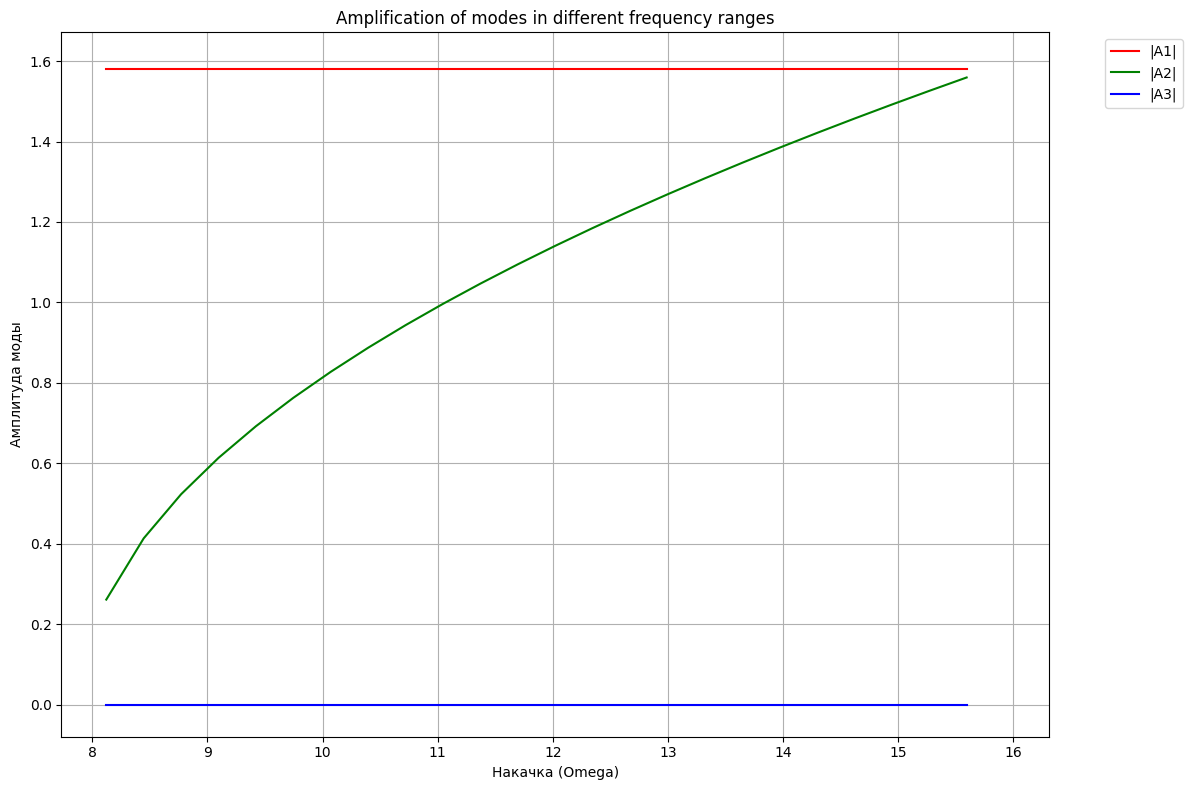

In [5]:
Omega_values = np.linspace(0,15.918367346938776, 50)

plt.figure(figsize=(12, 8))

mask = (Omega_values >= omega_zero) & (Omega_values <= omega_first)
A1_zero = np.array([np.abs(A1_st(gammas, Omega, 'zero')) for Omega in Omega_values[mask]])
A2_zero = np.array([np.abs(A2_st(gammas, Omega, 'zero')) for Omega in Omega_values[mask]])
A3_zero = np.array([np.abs(A3_st(gammas, Omega, 'zero')) for Omega in Omega_values[mask]])

plt.plot(Omega_values[mask], A1_zero, color='r', linestyle='-')
plt.plot(Omega_values[mask], A2_zero, color='g', linestyle='-')
plt.plot(Omega_values[mask], A3_zero, color='b', linestyle='-')

mask = (Omega_values >= omega_first) & (Omega_values <= omega_second)
A1_first = np.array([np.abs(A1_st(gammas, Omega, 'first')) for Omega in Omega_values[mask]])
A2_first = np.array([np.abs(A2_st(gammas, Omega, 'first')) for Omega in Omega_values[mask]])
A3_first = np.array([np.abs(A3_st(gammas, Omega, 'first')) for Omega in Omega_values[mask]])

plt.plot(Omega_values[mask], A1_first, label='|A1|', color='r', linestyle='-')
plt.plot(Omega_values[mask], A2_first, label='|A2|', color='g', linestyle='-')
plt.plot(Omega_values[mask], A3_first, label='|A3|', color='b', linestyle='-')

mask = Omega_values >= omega_second
A1_second = np.array([np.abs(A1_st(gammas, Omega, 'second')) for Omega in Omega_values[mask]])
A2_second = np.array([np.abs(A2_st(gammas, Omega, 'second')) for Omega in Omega_values[mask]])
A3_second = np.array([np.abs(A3_st(gammas, Omega, 'second')) for Omega in Omega_values[mask]])

plt.plot(Omega_values[mask], A1_second, color='r', linestyle='-')
plt.plot(Omega_values[mask], A2_second, color='g', linestyle='-')
plt.plot(Omega_values[mask], A3_second, color='b', linestyle='-')

# plt.axvline(x=omega_first, color='k', linestyle='-.', label='ω_first')
# plt.axvline(x=omega_second, color='k', linestyle=':', label='ω_second')

plt.xlabel('Накачка (Omega)')
plt.ylabel('Амплитуда моды')
plt.title('Amplification of modes in different frequency ranges')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout() 
plt.show()